In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"misbahjahan","key":"4d93143d069d176526de6e323748e535"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!cat ~/.kaggle/kaggle.json

{"username":"misbahjahan","key":"4d93143d069d176526de6e323748e535"}

In [6]:
# example
!kaggle datasets download -d puneet6060/intel-image-classification

 98% 339M/346M [00:05<00:00, 34.4MB/s]
100% 346M/346M [00:05<00:00, 64.0MB/s]


In [7]:
#unzip dataset in colab session
!unzip -q intel-image-classification.zip # -q for quiet

I

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# copy zipped dataset into your drive
!cp "intel-image-classification.zip" /content/drive/MyDrive/ML_A3

In [10]:
import numpy as np #//This line imports the NumPy library, which is commonly used for numerical operations in Python.
import pandas as pd #  data manipulation and analysis.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # working with images
import seaborn as sns #for statistical data visualization
import warnings
warnings.filterwarnings("ignore") # ignore unnecessary warnings
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import os # a way of interacting with the operating system, such as reading or writing files and directories.
from os import walk #The walk function generates file names in a directory tree by walking through the directory and its subdirectories recursively.
import tensorflow as tf
tf.random.set_seed(0) #This clears the TensorFlow session, releasing any resources held by the previous session. It's useful when you want to release memory after training or defining a model.
tf.keras.backend.clear_session() ##This clears the TensorFlow session, releasing any resources held by the previous session. It's useful when you want to release memory after training or defining a model.

In [12]:
classes = {"buildings":0,"forest":1,"glacier":2, "mountain":3, "sea":4, "street":5}
dir_train =  "/content/seg_train/seg_train"
dir_test = "/content/seg_test/seg_test"
dir_pred = "/content/seg_pred/seg_pred"

In [13]:
(dirpath_pred, dirnames_pred, fnames_pred) = next(walk(dir_pred))#current directory path, subdirectory, file names of prediction
print("Size of the prediction set is {}".format(len(fnames_pred)))

Size of the prediction set is 7301


In [49]:
def read_image_names_class(dpath): #The purpose of the read_image_names_class function is to read and organize image file names based on the class labels of subdirectories within a specified directory. Let's break down the key aspects of its purpose
    fnames = {}
    x, dirnames, y = next(walk(dpath))
    for d in dirnames:
        _,_,temp = next(walk(os.path.join(dpath,d)))
        fnames[classes[d]] = temp

    return dirnames, fnames

In [50]:
def sample_images_from_class(nsample, classname, path, fnames):
    sind = np.random.random_integers(1,len(fnames[classes[classname]]),nsample)
    spath = [os.path.join(path, classname, fnames[classes[classname]][i]) for i in sind]

    return spath

def plot_sampled_images(path, fnames):
    nsample = 3
    ncols = len(classes)

    fig, ax = plt.subplots(nsample, ncols, figsize=(20, 3*nsample))

    for i,cl in enumerate(classes.keys()):
        sp = sample_images_from_class(nsample, cl, path, fnames)
        for j,spj in enumerate(sp):
            img = mpimg.imread(spj)
            ax[j,i].imshow(img)
            ax[j,i].axis('off')
            ax[j,i].set_title(cl)


In [51]:
def sample_prediction_images(path, fnames, nsample):
    sind = np.random.random_integers(1,len(fnames), nsample)
    spj = []
    for sp in sind:

                spj.append(os.path.join(path, fnames[sp]))

    return spj

def plot_sampled_prediction_images(path, fnames):
    nsample = 3
    ncols = len(classes)

    fig, ax = plt.subplots(nsample, ncols, figsize=(20, 3*nsample))
    sind = np.random.random_integers(1,len(fnames), nsample*ncols)

    axs = ax.ravel()
    for i, sp in enumerate(sind):
        spj = os.path.join(path, fnames[sp])
        img = mpimg.imread(spj)
        axs[i].imshow(img)
        axs[i].axis('off')


In [52]:
def get_true_pred(model, ds):
    y = model.predict(ds)

    ytrue = []
    ypred = []

    ypred.append(np.argmax(y,axis=1))
    for img, lbl in ds:
        for l in lbl:
            ytrue.append(np.argmax(l.numpy()))
    return ytrue, ypred

In [53]:
def plot_confMat(ytrue, ypred):
    cm = confusion_matrix(y_true = ytrue,y_pred = ypred[0])
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_from_key(x) for x in range(6)])
    fig,ax = plt.subplots(1,1,figsize=(8,8))
    cmd.plot(include_values=True, cmap = plt.cm.Blues, ax=ax)

    plt.title("Accuracy score is {:.2f}".format(accuracy_score(y_true = ytrue,y_pred = ypred[0])))

def read_prepare_image_predict(fpath, mod):
    img = tf.keras.preprocessing.image.load_img(fpath, grayscale=False, color_mode='rgb')
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
    ax1.imshow(img)
    ax1.axis('off')

    parr = tf.keras.preprocessing.image.img_to_array(img)
    tparr = tf.expand_dims(parr, axis=0)

    pred = mod.predict(tparr)
    y = [p for p in pred[0]]
    x = [class_from_key(i) for i in range(6)]

    sns.barplot(x=x,y=y,ax=ax2)

    return pred

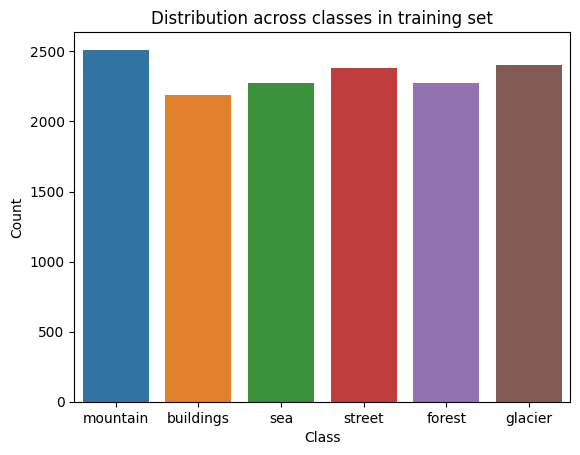

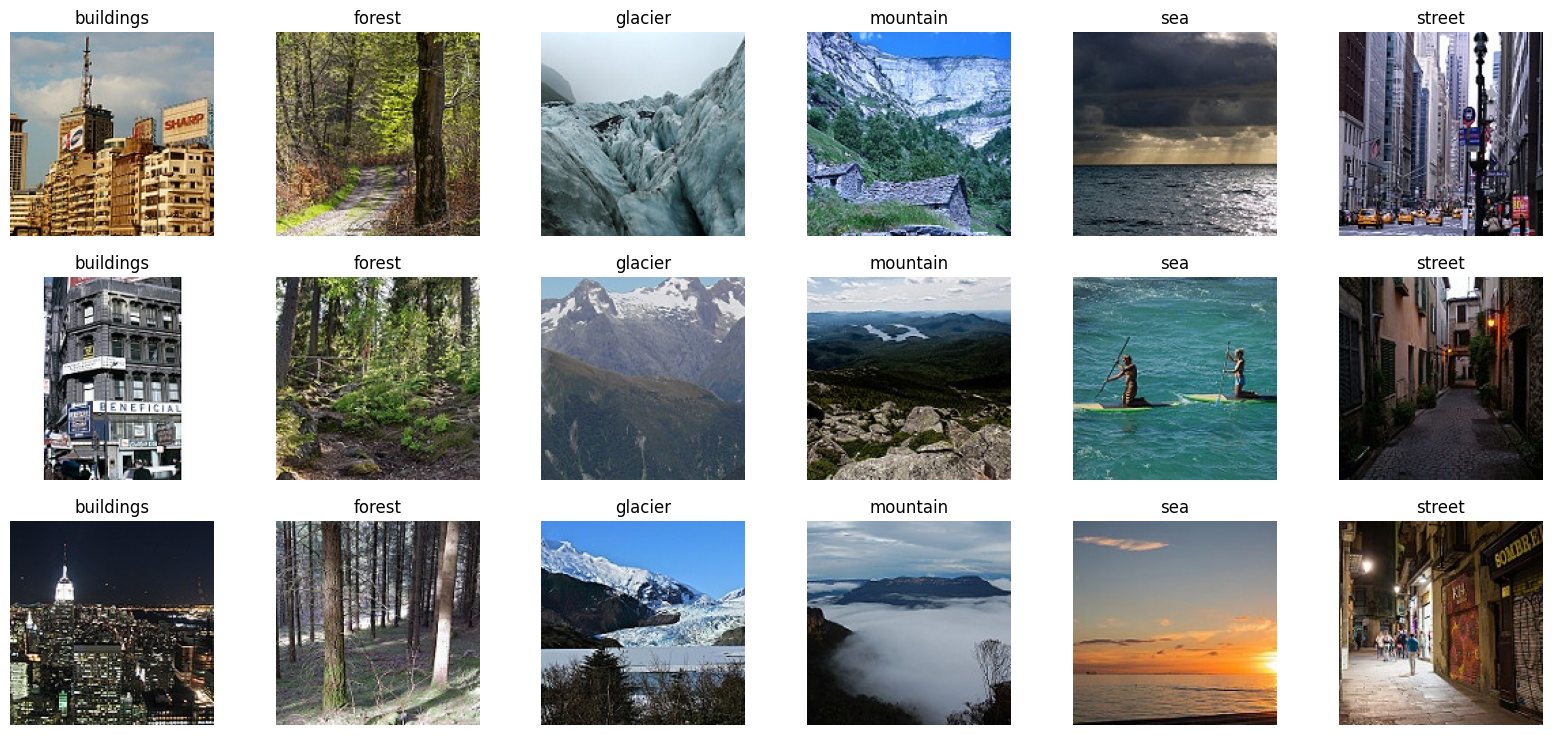

In [54]:
dirnames_train, fnames_train = read_image_names_class(dir_train)
train_summary = check_class_imbalance(fnames_train)
train_summary.head(10)
sns.barplot(data=train_summary, x = 'Class', y='Count').set_title("Distribution across classes in training set")
plot_sampled_images(dir_train, fnames_train)

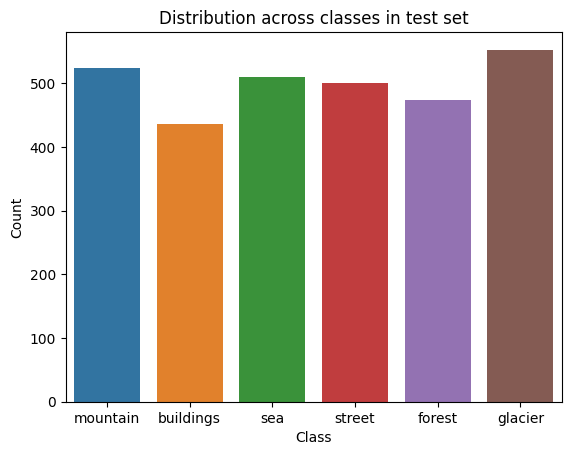

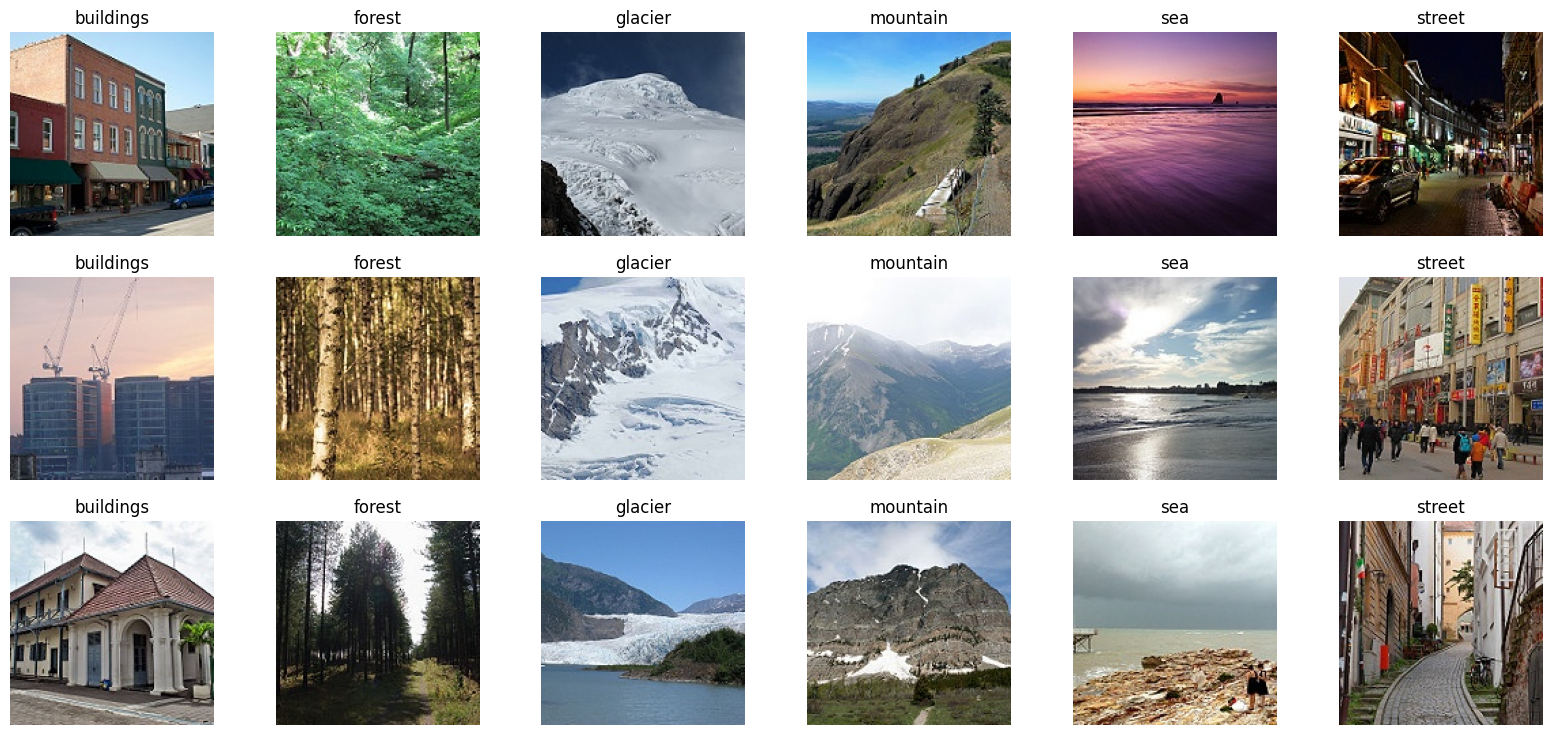

In [55]:
dirnames_test, fnames_test = read_image_names_class(dir_test)
test_summary = check_class_imbalance(fnames_test)
test_summary.head(10)

sns.barplot(data=test_summary, x = 'Class', y='Count').set_title("Distribution across classes in test set")

plot_sampled_images(dir_test, fnames_test)

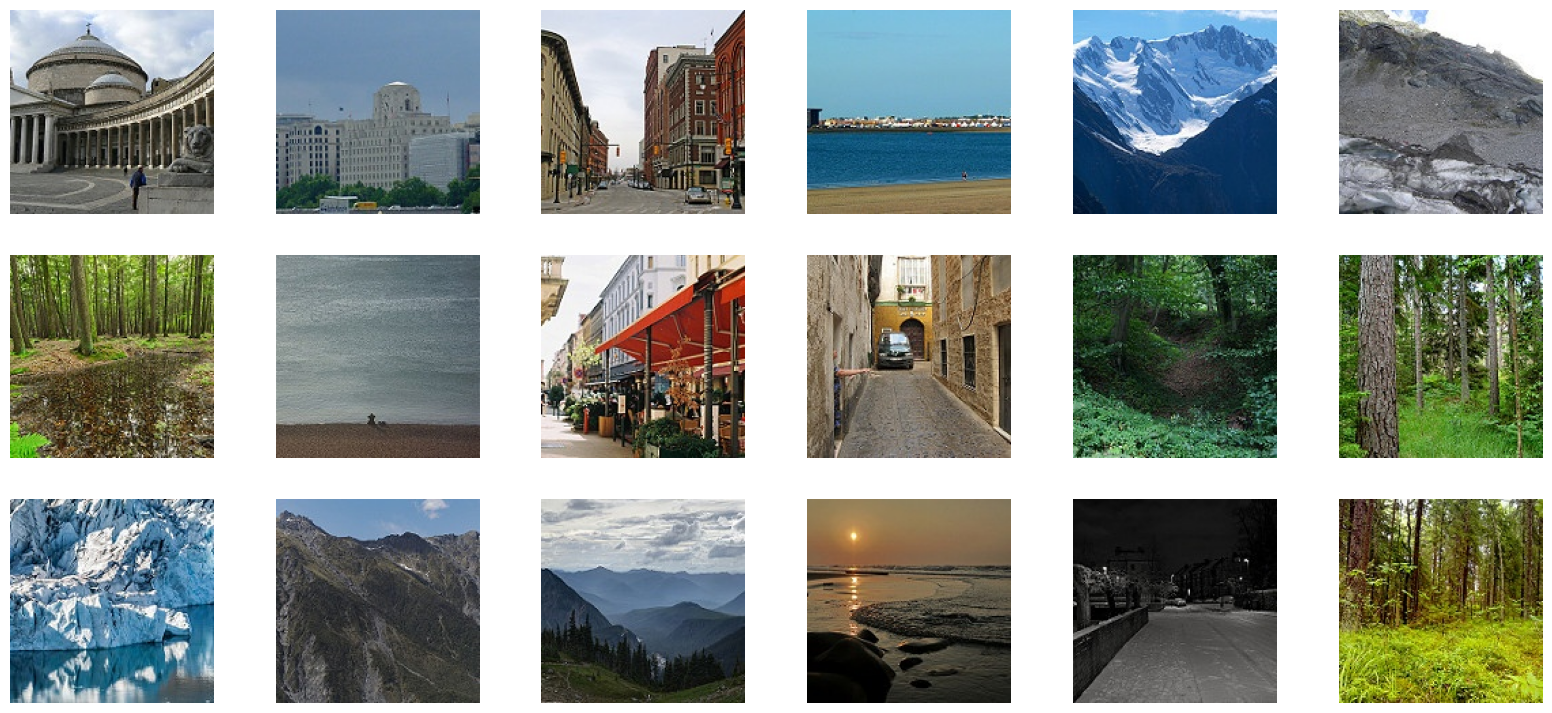

In [56]:
plot_sampled_prediction_images(dir_pred, fnames_pred)

DATA PREPROCESSING


In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [37]:
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    "/content/seg_train/seg_train",
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    "/content/seg_test/seg_test",
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


CONVOLUTIONAL LAYERS/Build CNN Model

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add more layers as needed

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=6, activation='softmax'))

Compile and Train the Model

In [40]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=3,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/3
439/439 [==============================] - 536s 1s/step - loss: 0.8270 - accuracy: 0.6980 - val_loss: 1.1416 - val_accuracy: 0.6190
Epoch 2/3
439/439 [==============================] - 548s 1s/step - loss: 0.7232 - accuracy: 0.7413 - val_loss: 0.7607 - val_accuracy: 0.7370
Epoch 3/3
439/439 [==============================] - 554s 1s/step - loss: 0.6757 - accuracy: 0.7576 - val_loss: 0.7485 - val_accuracy: 0.7537


In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 175232)            0         
                                                                 
 dense_3 (Dense)             (None, 128)               22429824  
                                                                 
 dense_4 (Dense)             (None, 6)                 774       
                                                                 
Total params: 22431494 (85.57 MB)
Trainable params: 22431494 (85.57 MB)
Non-trainable params: 0 (0.00 Byte)
____________

Evaluate the Model

In [42]:
test_generator = test_datagen.flow_from_directory(
    "/content/seg_test/seg_test",
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test accuracy: {test_acc}')

Found 3000 images belonging to 6 classes.
94/94 [==============================] - 26s 273ms/step - loss: 0.7485 - accuracy: 0.7537
Test accuracy: 0.7536666393280029
